# 1 - Perkenalan

Nama : Taufit Hidayat Watan

Batch : 10

Objective dari Milestone 2 ini adalah untuk mengevalusai pemelajaran terkait Covulational Learning Neural Network dengan menggunakan Tensorflow. Pada projcet Milestone 2 ini saya ingin membuat sebuah model yang mampu memprediksi apakah seekor sapi terinviksi virus Penyakik Mulut dan Kaki(PMK) atau Foot and Mouth Disease(FMD).
Image dataset yang saya gunakan adalah gambar yang saya kumpul dari internet dan kemudain saya perbanyak dengan menggunakan metode augmentasi.
Berikut adlah link dataset yang saya gunakan : 
https://www.kaggle.com/datasets/taufithidayatwatan/fmd-baru (image dataset awal)
https://www.kaggle.com/datasets/taufithidayatwatan/fmdbaru (dataset setelah augmentasi)

# 2 - Import Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from google.colab import files
from keras.preprocessing import image
import warnings
warnings.filterwarnings('ignore')

# 3 - Load Data

In [2]:
!mkdir -p ~/.kaggle #bikin folder di kaggle root
!cp kaggle.json ~/.kaggle # copy paster kaggle.json ke folder kaggle 

!mkdir ./kaggle #bikin folder kaggle di lokasi sama (bukan di root)
!mv ./kaggle.json ./kaggle #move atau pindahi file kaggle.json ke folder kaggle

In [3]:
!chmod 600 ~/.kaggle/kaggle.json #perizinan akses, hanya pemilik file yang memiliki akses baca dan tulis ke file
!ls ~/.kaggle #cek list data yang ada di folder kaggle

kaggle.json


In [3]:
!kaggle datasets download -d taufithidayatwatan/fmdbaru #dataset di download langsung dari kaggle


 92% 125M/136M [00:00<00:00, 181MB/s] 
100% 136M/136M [00:01<00:00, 119MB/s]


In [4]:
!unzip -q /content/fmdbaru.zip -d images #proses extraksi dataset kedalam folder image

In [5]:
os.listdir("/content/images/content/FMD-Baru") #ceklis isi folder FMD-Baru

['Not-Infected', 'Infected']

In [6]:
main_path = "/content/images/content/FMD-Baru" #FMD_BAru adalah main_path untuk proses pembuatan model CNN

In [7]:
print('test set: \n' + '='*50)
num_inf= len(os.listdir(os.path.join(main_path, 'Infected')))
num_ninf= len(os.listdir(os.path.join(main_path, 'Not-Infected')))
print(f'infected total= {num_inf}')
print(f'not-infected total= {num_ninf}')

test set: 
infected total= 452
not-infected total= 505


Disini saya ingin melihat jumlah total image di masing - masing label, dimana ada 452 image di label 'infected' dan 505 image di label 'not-infected'

In [8]:
inf = glob.glob(main_path+"/Infected/*.jpeg")
ninf = glob.glob(main_path+"/Not-Infected/*.jpeg")

Pada proses ini saya memisahkan image disetiap label untuk nantinya digabung kembali kedalam bentuk data frame

In [9]:
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

data = create_dataframe(inf + ninf)
data = data.sample(frac=1, random_state=1).reset_index(drop=True)

Proses image kedalam data frame.

In [10]:
data.head()

,images,label
0,/content/images/content/FMD-Baru/Infected/Infe...,Infected
1,/content/images/content/FMD-Baru/Infected/Infe...,Infected
2,/content/images/content/FMD-Baru/Not-Infected/...,Not-Infected
3,/content/images/content/FMD-Baru/Not-Infected/...,Not-Infected
4,/content/images/content/FMD-Baru/Infected/Infe...,Infected


# 4 - EDA

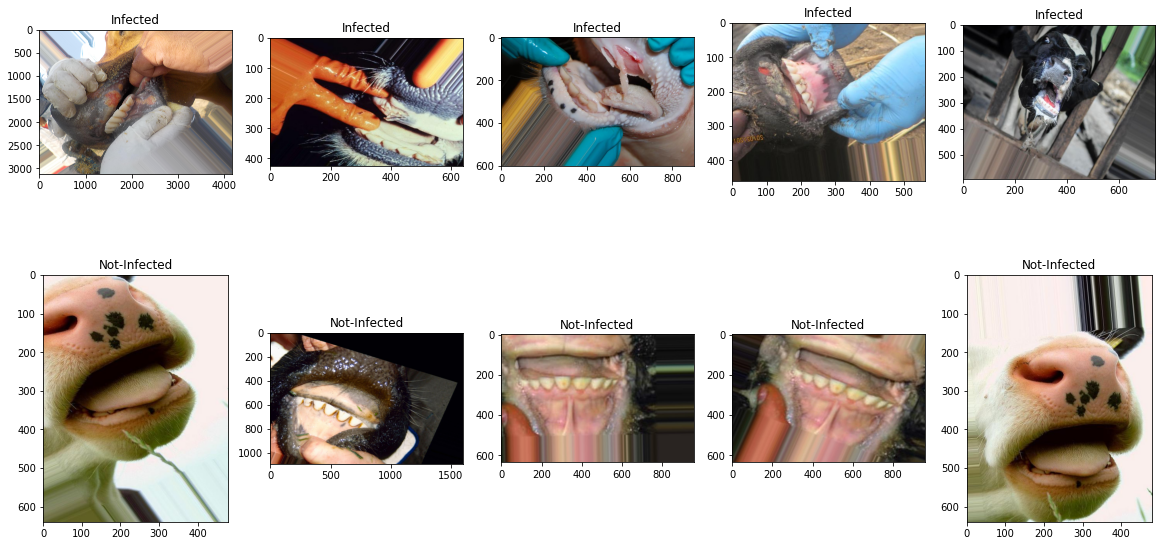

In [12]:
infected_samples = (data[data['label']=="Infected"]['images'].iloc[:5]).tolist()
not_infected_samples = (data[data['label']=="Not-Infected"]['images'].iloc[:5]).tolist()

def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(infected_samples + not_infected_samples)

Pada proses ini saya ingine melihat sample image dari masing - masing label sebanyak 5 sample.

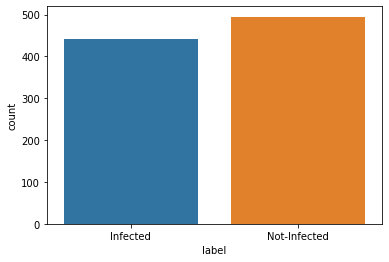

In [13]:
ax = sns.countplot(x="label", data=data)

Disini saya junga ingin melihat bagaimana perbandingan nilai dari masing - masing label, dimana hasilnya tidak seimbang tapi tidak masalah karena perbedaanya tidak terlalu jauh, dimana perbedaan ini tidak smpai sepulun 10%.

# 5 - Data Preprocessing

## Splitting Dataset

In [11]:
train_df, test_df = train_test_split(data, train_size=0.9, random_state = 19)
val_df, train_df = train_test_split(train_df, train_size=0.10, random_state = 19)

Dini saya membagi image kedalam train, val, dan test, dengan prporsi 90% untuk train dan masing - masing 10% untuk val dan test. Kenapa train mendapat proporsi sebanyak 10%, hal ini dikarenkan model akan butuh banyak data untuk di train, semkain banyak model melakukan training semkain baik pula lah kerja model tersebut.

## Setting Image

In [12]:
img_height = 220
img_width = 220
SEED = 1
BATCH = 32


Disini saya melakukan image setting dengan img_height = 220, img_width = 220, SEED = 1, BATCH = 32. Dimana img_heigt dan img_width akan dijadikan input_shape pada model.


## Tensor Pipeline

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

vaL_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Disini saya melakukan augmentasi dengan menggunakan ImageDataGenator, dimana disini dilakukan normalisis pixel seta melakukan sedikir perubahn untuk image pada data train.

In [14]:
ds_train = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width), 
    class_mode='binary',
    batch_size=BATCH,
    shuffle=True,
    seed=SEED)

ds_val = vaL_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

df_test = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    seed=SEED)

Found 759 validated image filenames belonging to 2 classes.
Found 84 validated image filenames belonging to 2 classes.
Found 94 validated image filenames belonging to 2 classes.


Pada proses ini saya membuat input pipline dengan menggunakan ".flow_from_dataframe". Dimana inputannya adalah hasil dari ImageDataGenerator dan data_frame image.

In [15]:
ds_train.class_indices

{'Infected': 0, 'Not-Infected': 1}

Disini saya ingine melihat nilai dari maisng - masing label dimana 0 untuk Infected dan 1 Untuk Not-Infected

# 6 - Model Defenition

In [16]:
input= [img_height, img_width,3]

base_model= Sequential()

#conv1
base_model.add(Conv2D(filters=16,kernel_size=3, activation= 'relu', input_shape=input))
base_model.add(MaxPooling2D(pool_size=2, strides=2))

#conv2
base_model.add(Conv2D(filters=32,kernel_size=3, activation= 'relu'))
base_model.add(MaxPooling2D(pool_size=2, strides=2))

base_model.add(Flatten())
base_model.add(Dense(units=128, activation='relu'))
base_model.add(Dense(units=1, activation='sigmoid'))

API yang digunakan pada model kali ini dalah Sequntial API, dengan menggunakan 2 Convulation layer dan 1 Dense layer.

In [35]:
callback=EarlyStopping(monitor='val_loss', mode= 'min', patience=3, verbose=1)

Disni saya juga membuat sebuah callback EarlyStoping dengan fokus pada val_loss.

In [21]:
base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])

Disini saya melkukan model compile dengan menggunakan optimizer adam serta loss binary_crossentropy karena hanya ada 2 kelas atau label serta metrics yang accuracy.

# 7 - Model Training

In [22]:
history= base_model.fit(ds_train, batch_size=BATCH, epochs=30, validation_data= ds_val, callbacks= callback, verbose=1)

Epoch 1/30
24/24 [==============================] - 34s 920ms/step - loss: 1.0844 - accuracy: 0.6456 - val_loss: 0.4635 - val_accuracy: 0.8452
Epoch 2/30
24/24 [==============================] - 22s 928ms/step - loss: 0.5117 - accuracy: 0.7681 - val_loss: 0.3954 - val_accuracy: 0.8571
Epoch 3/30
24/24 [==============================] - 22s 899ms/step - loss: 0.4332 - accuracy: 0.8195 - val_loss: 0.3499 - val_accuracy: 0.8452
Epoch 4/30
24/24 [==============================] - 21s 892ms/step - loss: 0.3766 - accuracy: 0.8406 - val_loss: 0.2558 - val_accuracy: 0.8929
Epoch 5/30
24/24 [==============================] - 21s 896ms/step - loss: 0.2526 - accuracy: 0.9012 - val_loss: 0.1622 - val_accuracy: 0.9167
Epoch 6/30
24/24 [==============================] - 21s 890ms/step - loss: 0.2547 - accuracy: 0.8972 - val_loss: 0.1335 - val_accuracy: 0.9881
Epoch 7/30
24/24 [==============================] - 21s 869ms/step - loss: 0.1809 - accuracy: 0.9262 - val_loss: 0.1531 - val_accuracy: 0.9048

Disini model di train dengan epochs sebanyak 10 kali.

# 8 - Model Evaluation

In [23]:
metrics = pd.DataFrame(history.history)
metrics.tail()

,loss,accuracy,val_loss,val_accuracy
14,0.064784,0.977602,0.016233,1.000000
15,0.067290,0.978920,0.018463,1.000000
16,0.055672,0.977602,0.009162,1.000000
17,0.056067,0.980237,0.019015,1.000000
18,0.039811,0.990777,0.023839,0.988095


Dari hasil evaluasi dapat dilihat pada tabel di atas accuracy model sangat bagus yaitu sebesar 90%.

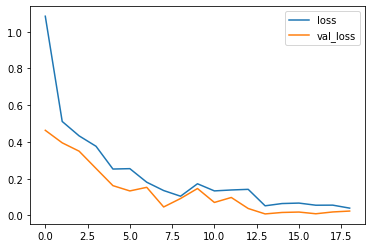

In [24]:
metrics[['loss', 'val_loss']].plot();


Jika dilihat dengan menggunakan lineplot, model ini cukup bagus karena tidak over fit serta tidak terjadi gardient exploding, selain itu nilai val_los juga cenderung turun.

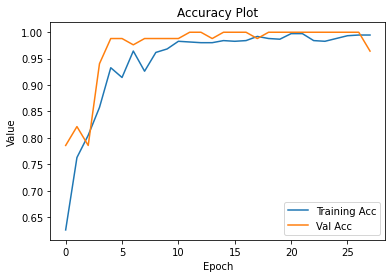

In [ ]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()


Selain itu jika dilihat pada plot acuracy, model ini juga bisa dikatakan cukup baik, karena nilai validation accuraty maupun test accuracynya cenderung naik.

In [ ]:
test_loss, test_accuracy = base_model.evaluate(df_test, verbose=0)
test_loss = round(test_loss, 6)
test_accuracy = round(test_accuracy*100, 3)

print('Test Loss: ', test_loss)
print('Test Accuracy:', '\033[0m', test_accuracy, '%\033[0m')

Test Loss:  0.022403
Test Accuracy:  98.936 %


In [ ]:
train_acc = round(np.max(history.history['accuracy'])*100, 2)
valid_acc = round(np.max(history.history['val_accuracy'])*100,2)

print('Training Accuracy:','\033[0m', train_acc, '%\033[0m')
print('Validation Accuracy:','\033[0m', valid_acc, '%\033[0m')
print('Test Accuracy:', '\033[0m', test_accuracy,'%\033[0m')

Training Accuracy:  99.74 %
Validation Accuracy:  100.0 %
Test Accuracy:  98.936 %


Jika dilihat dari secara persentase, model ini sangat bagus karena punya nilai traingin, validation, dan test accuracy yang sangat - sangat tinggi.

# 9 - Model Improvment

Karena model sudah memiliki pefroma yang baik, disini saya melakukan fine tuning untuk melihat apakah pefroma model bisa lebih baik lagi atau tidak.

## Manual Tuning

In [36]:
input= [img_height, img_width,3]

model_1= Sequential()

#conv1
model_1.add(Conv2D(filters=32,kernel_size=3, activation= 'relu', input_shape=input))
model_1.add(MaxPooling2D(pool_size=2, strides=2))
model_1.add(Dropout(0.5))

#conv2
model_1.add(Conv2D(filters=64,kernel_size=3, activation= 'relu'))
model_1.add(MaxPooling2D(pool_size=2, strides=2))
model_1.add(Dropout(0.3))

model_1.add(Flatten())
model_1.add(Dense(units=32, activation='relu'))
model_1.add(Dense(units=1, activation='sigmoid'))


Disini saya melakukan manual tuning dengan menambahkah kan Dropuot pada masing - masing Convulational layers serta mengganti jumlah units pada dense layer menjadi 32.

In [37]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])

In [38]:
history_1 = model_1.fit(ds_train, batch_size=BATCH, epochs=30, validation_data= ds_val, callbacks= callback, verbose=1)

Epoch 1/30
24/24 [==============================] - 23s 935ms/step - loss: 2.0857 - accuracy: 0.5244 - val_loss: 0.6930 - val_accuracy: 0.5238
Epoch 2/30
24/24 [==============================] - 22s 907ms/step - loss: 0.6839 - accuracy: 0.5362 - val_loss: 0.6900 - val_accuracy: 0.5476
Epoch 3/30
24/24 [==============================] - 22s 901ms/step - loss: 0.6449 - accuracy: 0.6061 - val_loss: 0.6279 - val_accuracy: 0.6548
Epoch 4/30
24/24 [==============================] - 22s 906ms/step - loss: 0.6042 - accuracy: 0.6746 - val_loss: 0.6286 - val_accuracy: 0.7381
Epoch 5/30
24/24 [==============================] - 21s 894ms/step - loss: 0.6166 - accuracy: 0.6482 - val_loss: 0.6446 - val_accuracy: 0.7500
Epoch 6/30
24/24 [==============================] - 22s 895ms/step - loss: 0.5839 - accuracy: 0.6733 - val_loss: 0.5973 - val_accuracy: 0.7262
Epoch 7/30
24/24 [==============================] - 22s 875ms/step - loss: 0.5818 - accuracy: 0.7009 - val_loss: 0.5665 - val_accuracy: 0.7024

Disini saya melakukan train pada model baru dengan menggunkan 30 epochs.

In [39]:
metrics_1 = pd.DataFrame(history_1.history)
metrics_1.tail()

,loss,accuracy,val_loss,val_accuracy
9,0.557979,0.711462,0.565658,0.750000
10,0.553330,0.716733,0.559207,0.750000
11,0.552783,0.723320,0.585176,0.785714
12,0.519489,0.750988,0.574398,0.750000
13,0.499386,0.805007,0.560966,0.785714


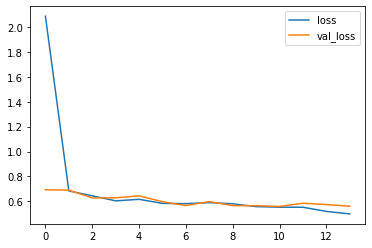

In [40]:
metrics_1[['loss', 'val_loss']].plot();

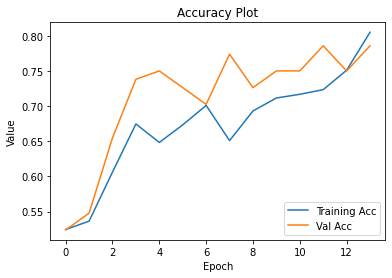

In [41]:
plt.plot(history_1.history['accuracy'], label='Training Acc')
plt.plot(history_1.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()


Hasilnya model baru lebih stabil di bandingkan base_model.

## Fine Tuning

In [ ]:
model_imp= Sequential()

#conv1
model_imp.add(Conv2D(filters=16,kernel_size=3, activation= 'relu', input_shape=input))
model_imp.add(MaxPooling2D(pool_size=2, strides=2))

#conv2
model_imp.add(Conv2D(filters=32,kernel_size=3, activation= 'relu'))
model_imp.add(MaxPooling2D(pool_size=2, strides=2))

model_imp.add(Flatten())
model_imp.add(Dense(units=128, activation='relu'))
model_imp.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model_imp.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("fmd_model1.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

Disini saya melakukan set callback dengan menggunakan LearningRateScheduler yang menggunakan exponential_decay serta melakukan restore pada best_weights.

In [ ]:
history_imp = model_imp.fit(
    ds_train,
    epochs=30,
    validation_data=ds_val,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/30
24/24 [==============================] - 23s 937ms/step - loss: 3.7529 - accuracy: 0.5046 - val_loss: 0.6957 - val_accuracy: 0.4643 - lr: 0.0100
Epoch 2/30
24/24 [==============================] - 21s 893ms/step - loss: 0.6918 - accuracy: 0.5296 - val_loss: 0.6978 - val_accuracy: 0.4643 - lr: 0.0089
Epoch 3/30
24/24 [==============================] - 22s 906ms/step - loss: 0.6917 - accuracy: 0.5296 - val_loss: 0.6989 - val_accuracy: 0.4643 - lr: 0.0079
Epoch 4/30
24/24 [==============================] - 21s 899ms/step - loss: 0.6916 - accuracy: 0.5296 - val_loss: 0.6985 - val_accuracy: 0.4643 - lr: 0.0071
Epoch 5/30
24/24 [==============================] - 21s 894ms/step - loss: 0.6915 - accuracy: 0.5296 - val_loss: 0.6983 - val_accuracy: 0.4643 - lr: 0.0063
Epoch 6/30
24/24 [==============================] - 21s 902ms/step - loss: 0.6915 - accuracy: 0.5296 - val_loss: 0.6988 - val_accuracy: 0.4643 - lr: 0.0056
Epoch 7/30
24/24 [==============================] - 21s 889ms/st

Setelah itu model fine tuning di treain dengan epochs sebanyak 30 kali.

In [ ]:
metrics_2 = pd.DataFrame(history_imp.history)
metrics_2.tail()

,loss,accuracy,val_loss,val_accuracy,lr
6,0.691508,0.529644,0.698942,0.464286,0.005012
7,0.691523,0.529644,0.699070,0.464286,0.004467
8,0.691442,0.529644,0.699119,0.464286,0.003981
9,0.691625,0.529644,0.698517,0.464286,0.003548
10,0.691461,0.529644,0.698660,0.464286,0.003162


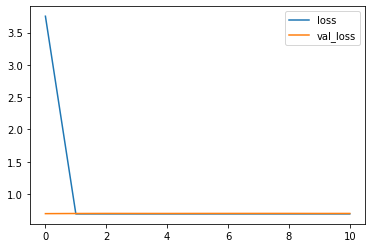

In [ ]:
metrics_2[['loss', 'val_loss']].plot();

Dan hasilnya tidak lebih baik dari pada base model bahkan sangat jauh jika dibandingkan dengan base_model dan model dengan manual tuning.

In [ ]:
train_acc_imp = round(np.max(history_imp.history['accuracy'])*100, 2)
valid_acc_imp = round(np.max(history_imp.history['val_accuracy'])*100,2)

print('Training Accuracy:','\033[0m', train_acc_imp, '%\033[0m')
print('Validation Accuracy:','\033[0m', valid_acc_imp, '%\033[0m')

Training Accuracy:  52.96 %
Validation Accuracy:  46.43 %


Dan jika dilihat secara persentase hasilnya sangat jauh, setengah dari base model base_model dan model dengan manual tuning.

# 10 - Save Model

Karena model dengan manual tuning adalah model terbaik, maka model inilah yang akan di save dan akan di deploy.

In [28]:
base_model.save('FMD_Base.h5')

# 11 - Model Inference

Disini saya melakukan model inference dengan menggunakan gambar yang di upload.

Saving 6.jpg to 6 (1).jpg


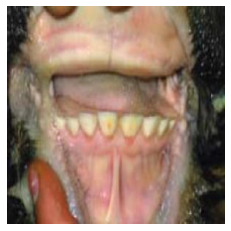

[[1.]]
Not - Infected


In [42]:
import numpy as np


uploaded = files.upload()

for fn in uploaded.keys():
 
 
  path = fn
  img = image.load_img(path, target_size=(220,220))
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) 
  x = np.expand_dims(x, axis=0) 
  images = np.vstack([x])
  classes = base_model.predict(images) 
  print(classes) 
  if classes[0][0] == 1:
    print('Not - Infected')
  else:
    print('Infected')

Saving 3.jpg to 3.jpg


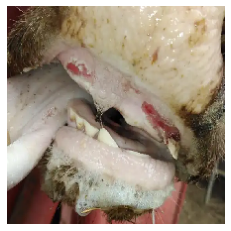

[[0.46344557]]
Infected


In [43]:
uploaded = files.upload()

for fn in uploaded.keys():
 
 
  path = fn
  img = image.load_img(path, target_size=(220,220))
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) 
  x = np.expand_dims(x, axis=0) 
  images = np.vstack([x])
  classes = model_1.predict(images) 
  print(classes) 
  if classes[0][0] == 1:
    print('Not - Infected')
  else:
    print('Infected')

Dan hasilnya model mampu memprediksi dengan baik.

# 12 - Kesimpulan

Tujuan dari pengerjaan project ini adalah untuk membuat sebuah model yang mampu mendeteksi apakah seekor sapi terinveksi virus PMK atau tidak. Dalam proses pengerjaannya dimulai dari load data, EDA, preporcessing, tensorflow pipeline, model training, model evaluation, model improvment dan terakhir model inference. Beberapa ponit yang dapat diambil adalah sebagai berikut:

1. Base model memliki pefroma yang luar biasa jika dilihat dari segi akurasi, tapi base model ini kurang stabil. Oleh karena itu perlu dilakukan model improvemnt untuk lebih meningkatkan base model.

2. Untuk model imrovment sendiri dilakukan dengan dua cara, pertama manual improvement atau tuning, dan kedua dengan melalukakn fine tuning. Untuk manual tuning hal yang dilakukan adalah merubah umbah units pada masing - masing convulational layer, menambahkan dropout pada masing - masing convulational layers, dan menurunkan jumlah unit pada dense layer. Untuk fine tuning cara yang diterapkan adalah dengan melakukan restore best weight dan melakukan rescheduler pada learning rate. Dan hasilnya adalah hasil dari manual tuning lah yang terbaik, dimana selain akursai yang tinggi yaitu di atas 96%, model dengan manual tuning juga memilki kestabilan yang sangat bagus. Sedangkan untuk model yang menggunakan fine tuning hasilnya sangat tidak memuaskan, dimana hanya memiliki akurasi sebesar 59%.

3. Untuk beberapa test inference yang dilakukan hasilnya cukup akurat, tetapi ada juga beberapa test yang miss predict, walaupun sudah menggunakan modeldengan manual tuning yang memiliki peforma terbaik, hal ini di karenakan image yang sedikit kemudian di perbanyak dengan augmentasi. Proses augmentasi ini akan menyebabkan salah miss predict karean hanay gambar yang sama yang diperbanyak dan hanya merubah - rubah pola dan tidak terlalu banyak perbedaan pada image yang digunakan sebagai dataset.

